
# 2D Refraction modeling and inversion

This example shows how to use the TravelTime manager to generate the response
of a three-layered sloping model and to invert the synthetic noisified data.


In [6]:
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import TravelTimeManager

## Model setup
We start by creating a three-layered slope (The model is taken from the BSc
thesis of Constanze Reinken conducted at the University of Bonn).



(<Axes: >, None)

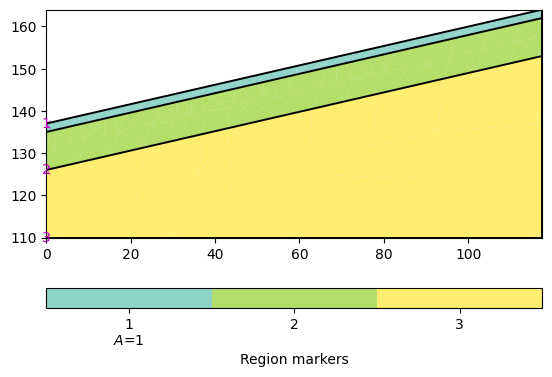

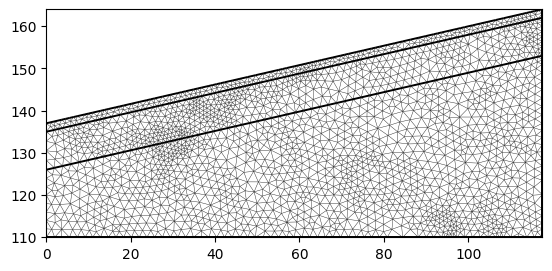

In [2]:
layer1 = mt.createPolygon([[0.0, 137], [117.5, 164], [117.5, 162], [0.0, 135]],
                          isClosed=True, marker=1, area=1)
layer2 = mt.createPolygon([[0.0, 126], [0.0, 135], [117.5, 162], [117.5, 153]],
                          isClosed=True, marker=2)
layer3 = mt.createPolygon([[0.0, 110], [0.0, 126], [117.5, 153], [117.5, 110]],
                          isClosed=True, marker=3)

slope = (164 - 137) / 117.5

geom = layer1 + layer2 + layer3

# If you want no sloped flat earth geometry .. comment out the next 2 lines
# geom = mt.createWorld(start=[0.0, 110], end=[117.5, 137], layers=[137-2, 137-11])
# slope = 0.0

pg.show(geom)

mesh = mt.createMesh(geom, quality=34.3, area=3, smooth=[1, 10])
pg.show(mesh)

Next we define geophone positions and a measurement scheme, which consists of
shot and receiver indices.



In [3]:
numberGeophones = 48
sensors = np.linspace(0., 117.5, numberGeophones)
scheme = pg.physics.traveltime.createRAData(sensors)

# Adapt sensor positions to slope
pos = np.array(scheme.sensors())
for x in pos[:, 0]:
    i = np.where(pos[:, 0] == x)
    new_y = x * slope + 137
    pos[i, 1] = new_y

scheme.setSensors(pos)

## Synthetic data generation
Now we initialize the TravelTime manager and asssign P-wave velocities to the
layers. To this end, we create a map from cell markers 0 through 3 to
velocities (in m/s) and generate a velocity vector. To check whether the
model looks correct, we plot it along with the sensor positions.



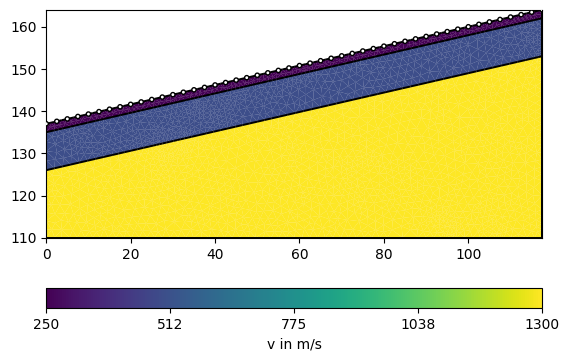

In [4]:
mgr = TravelTimeManager()
vp = np.array(mesh.cellMarkers())
vp[vp == 1] = 250
vp[vp == 2] = 500
vp[vp == 3] = 1300

ax, _ = pg.show(mesh, vp, colorBar=True, logScale=False, label='v in m/s')
pg.viewer.mpl.drawSensors(ax, scheme.sensors(), diam=1.0,
                         facecolor='white', edgecolor='black')

We use this model to create noisified synthetic data and look at the
traveltime data matrix. Note, we force a specific noise seed as we want
reproducable results for testing purposes.
TODO: show first arrival traveltime curves.



28/09/23 - 00:59:22 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


min/max t: 0.008790995543598544 0.14101993727141843


(<Axes: >, None)

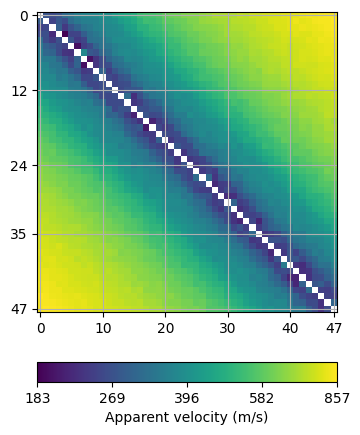

In [5]:
data = mgr.simulate(slowness=1.0 / vp, scheme=scheme, mesh=mesh,
                    noiseLevel=0.001, noiseAbs=0.001, seed=1337,
                    verbose=True)

data.save('simple.dat')

mgr.showData(data)

## Inversion
Now we invert the synthetic data. We need a new independent mesh without
information about the layered structure. This mesh can be created manual or
guessd automatic from the data sensor positions (in this example). We
tune the maximum cell size in the parametric domain to 15m²



In [6]:
vest = mgr.invert(data, secNodes=2, paraMaxCellSize=15.0,
                  maxIter=10, verbose=True)
np.testing.assert_array_less(mgr.inv.inv.chi2(), 1.1)

./core/src/meshentities.cpp:36		GIMLI::Boundary* GIMLI::findBoundary_(const std::set<Boundary*>&)  pls. check, this should not happen.  There is more then one boundary defined.2
Boundary 0x562b8335ff90 rtti: 22 id: 0	N: 0 1  marker: 1 
Boundary 0x562b833cc1b0 rtti: 22 id: 96	N: 4 0  marker: -1 
06/09/23 - 21:57:59 - pyGIMLi - INFO - Found 1 regions.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  0

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  0

Statistics:

  Input vertices: 97
  Input segments: 98
  Input holes: 0

  Mesh vertices: 675
  Mesh triangles: 1198
  Mesh edges: 1872
  Mesh exterior boundary edges: 150
  Mesh interior boundary edges: 0
  Mesh subsegments (constrained edges): 150



06/09/23 - 21:58:00 - pyGIMLi - INFO - Found 1 regions.
06/09/23 - 21:58:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
06/09/23 - 21:58:00 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
06/09/23 - 21:58:00 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
06/09/23 - 21:58:00 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00163632 0.00184202 0.00167135 ... 0.00020591 0.00036039 0.00034173]
06/09/23 - 21:58:00 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 876.409/991.286
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7f7b6804e840>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f7b681cd6c0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7f7b6804e980>
min/max (data): 0.0069/0.14
min/max (error): 0.8%/14.67%
min/max (start model): 2.0e-04/0.002
--------------------------------------------------------------------------------
min/max(dweight) = 876.409/991.286
Building constraints matrix
constraint matrix of size(nBounds x nModel) 1722 x 1198
check Jacobian: wrong dimensions: (0x0) should be (2256x1198)  force: 1
jacobian size invalid, forced recalc: 1
calculating jacobian matrix (forced=1)...--------------------------------------------------------------------------------... 0.583736 s
min data = 0.00687528 max data = 0.142381 (2256)
min error = 0.00801383 max error = 0.146727 (2256)
min response = 0.00487086 max response = 0.0870827 (2256)
calc without referen

The manager also holds the method showResult that is used to plot the result.
Note that only covered cells are shown by default.
For comparison we plot the geometry on top.



(<Axes: >, None)

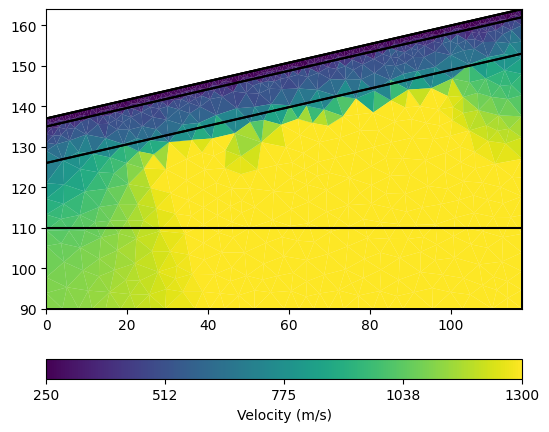

In [7]:
ax, _ = mgr.showResult(cMin=min(vp), cMax=max(vp), logScale=False)
pg.show(geom, ax=ax, fillRegion=False, regionMarker=False)

Note that internally the following is called

```python
ax, _ = pg.show(ra.mesh, vest, label="Velocity [m/s]", **kwargs)
```


Another useful method is to show the model along with its response
on the data.



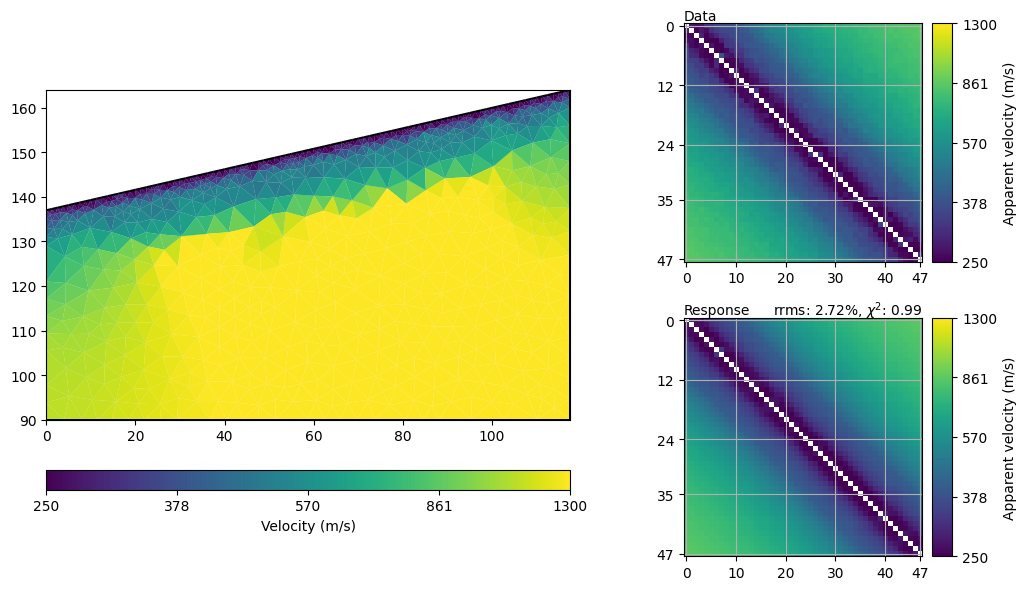

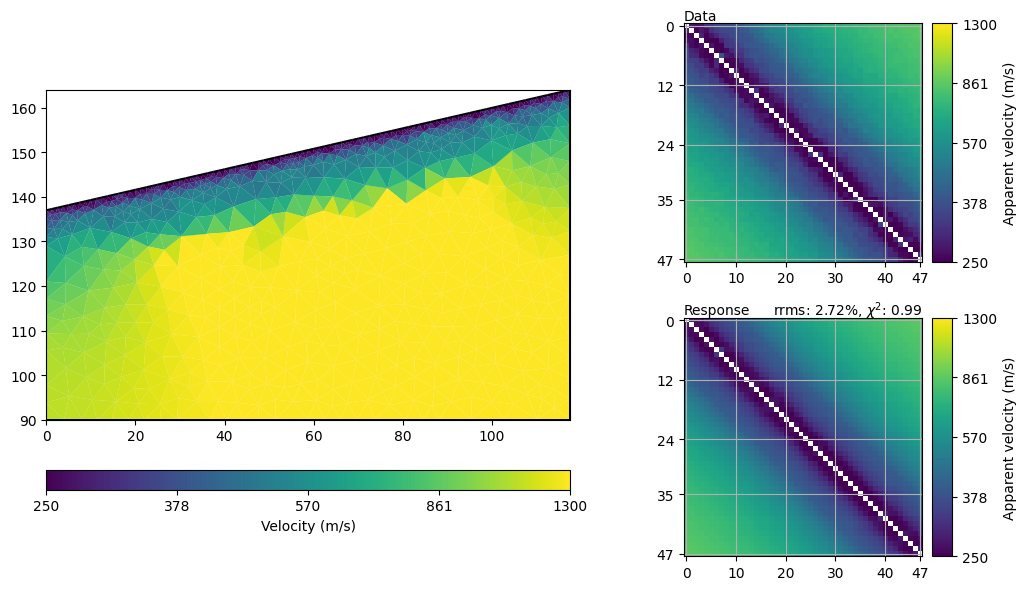

In [8]:
mgr.showResultAndFit(cMin=min(vp), cMax=max(vp))